**All the imports Needed**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import os

**Reading Data**

In [33]:
data_csv = pd.read_csv("data1.csv")
print(data_csv.head())

                           Quiz Name  Class  ZipGrade ID  External Id  \
0  Level 0 Cluny Convent High School    NaN      5012026          NaN   
1  Level 0 Cluny Convent High School    NaN      5012025          NaN   
2  Level 0 Cluny Convent High School    NaN      5012024          NaN   
3  Level 0 Cluny Convent High School    NaN      5012022          NaN   
4  Level 0 Cluny Convent High School    NaN      5012021          NaN   

   First Name  Last Name  Num Questions  Num Correct  Percent Correct  \
0         NaN        NaN            180           64          35.5556   
1         NaN        NaN            180           60          33.3333   
2         NaN        NaN            180           36          20.0000   
3         NaN        NaN            180           44          24.4444   
4         NaN        NaN            180           60          33.3333   

   Key Version ...   Q36  Q37  Q38  Q39  Q40  Q41  Q42  Q43  Q44  Q45  
0            1 ...     4    0    0    4    0    4 

**Data transposing, skill labelling and difficulty labelling of questions**

In [6]:
questionStartIndex=1
questionEndIndex=45
numQuestions=(questionEndIndex-questionStartIndex+1)
numberOfDifficultyLevels=5.0
if((questionEndIndex-questionStartIndex+1)%numberOfDifficultyLevels!=0):
    print('There is uneven divide in the difficulty levels. Please look into it.')
else:
    print('Each difficulty level has same number of questions.This is nice!')
questionsInEachDifficultyLevel=(questionEndIndex-questionStartIndex+1)/numberOfDifficultyLevels
q_cols = ['Q' + str(i) for i in range(questionStartIndex,questionEndIndex+1)]
answerCols=data_csv[q_cols]
numStudents=answerCols.shape[0]
# correctResponsesForEachQuestion=answerCols.astype(bool).sum(axis=0)
# sortedcorrectResponsesForEachQuestion=correctResponsesForEachQuestion.sort_values(ascending=True)
# sortedcorrectResponsesForEachQuestionDf=sortedcorrectResponsesForEachQuestion.to_frame()
transposed_df=answerCols.transpose()
transposed_df['numCorrect']=transposed_df.astype(bool).sum(axis=1)
transposed_df['qid'] = range(questionStartIndex, questionStartIndex+len(transposed_df))
transposed_df['correctPercentage']=transposed_df['numCorrect']*100.0/numStudents
transposed_df['skillType']=0
transposed_df.loc[(transposed_df['qid']>=1)&(transposed_df['qid']<=10),'skillType' ]=1
transposed_df.loc[(transposed_df['qid']>=11)&(transposed_df['qid']<=20),'skillType' ]=2
transposed_df.loc[(transposed_df['qid']>=21)&(transposed_df['qid']<=30),'skillType' ]=3
transposed_df.loc[(transposed_df['qid']>=31)&(transposed_df['qid']<=40),'skillType' ]=4
transposed_df.loc[(transposed_df['qid']>=41)&(transposed_df['qid']<=45),'skillType' ]=5
colsReqd=['numCorrect','qid','correctPercentage','skillType']
reqdDf=transposed_df[colsReqd].sort_values('correctPercentage',ascending=False)
reqdDf['difficulty_level']=0
for i in range(1,int(numberOfDifficultyLevels+1)):
    reqdDf.iloc[int((i-1)*questionsInEachDifficultyLevel):int((i)*questionsInEachDifficultyLevel),-1]=i

Each difficulty level has same number of questions.This is nice!


**Histogram of Question number to percentage of people who answered it correctly**

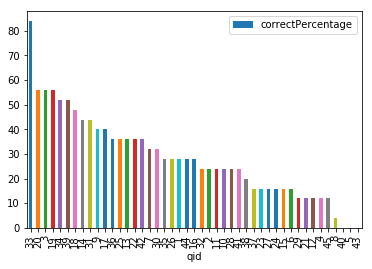

In [31]:
reqdDf.plot(kind='bar',x='qid',y='correctPercentage')

**Table of Question Wise Details ie. percentageCorrectlyAnswered, skill-type and difficulty-level**

In [10]:
print(reqdDf.sort_values('qid'))

     numCorrect  qid  correctPercentage  skillType  difficulty_level
Q1            7    1               28.0          1                 3
Q2            6    2               24.0          1                 3
Q3           14    3               56.0          1                 1
Q4            3    4               12.0          1                 5
Q5            0    5                0.0          1                 5
Q6            4    6               16.0          1                 4
Q7            8    7               32.0          1                 2
Q8            1    8                4.0          1                 5
Q9           10    9               40.0          1                 2
Q10           6   10               24.0          1                 3
Q11           6   11               24.0          2                 3
Q12           3   12               12.0          2                 5
Q13           9   13               36.0          2                 2
Q14          11   14              

**Skill-Wise Difficulty Information**

           difficulty_level  skillType
skillType                             
1                       3.3          1
2                       2.3          2
3                       3.5          3
4                       2.5          4
5                       3.8          5


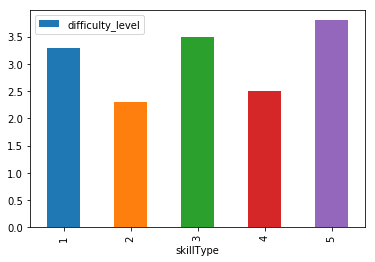

In [30]:
skillDifficultyDf=(reqdDf.groupby(['skillType'])['difficulty_level'].mean()).to_frame()
skillDifficultyDf['skillType']=skillDifficultyDf.index
print(skillDifficultyDf)
skillDifficultyDf.plot(kind='bar',x='skillType',y='difficulty_level')

**End of Task1**

**Start of Task2**

**Assigning Weight to each question as (1-fractionOfPeopleWhoAnsweredCorrectly)**

In [40]:
reqdDf['weight']=1-(reqdDf['correctPercentage']/100)
print(reqdDf.head())

     numCorrect  qid  correctPercentage  skillType  difficulty_level  weight
Q33          21   33               84.0          4                 1    0.16
Q20          14   20               56.0          2                 1    0.44
Q3           14    3               56.0          1                 1    0.44
Q19          14   19               56.0          2                 1    0.44
Q34          13   34               52.0          4                 1    0.48


**Calculating data for each student**

In [92]:
studentIdArray=data_csv['ZipGrade ID'].values
responsesArray=answerCols.values
dict_correctResponses={}
dict_wrongResponses={}
skillWiseScore={}
for t in range(numStudents):
    currStudentId=studentIdArray[t]
    currResponses=responsesArray[t]
    currDf=reqdDf.copy()
    currDf['response']=currResponses
    currDf['qStr']=currDf.index
    currDf.head()
    correctMask=(currDf['response'].astype(bool)==True)
    incorrectMask=(currDf['response'].astype(bool)==False)
    correctlyAnsweredQuestions=currDf['qStr'][correctMask].values
    wronglyAnsweredQuestions=currDf['qStr'][incorrectMask].values
    dict_correctResponses[currStudentId]=correctlyAnsweredQuestions
    dict_wrongResponses[currStudentId]=wronglyAnsweredQuestions
    curr_skill_weight_df=(currDf[correctMask].groupby(['skillType'])['weight'].sum().to_frame())
    for c_skillType in range(1,6):
        if(c_skillType not in curr_skill_weight_df.index):
            curr_skill_weight_df[c_skillType]=0.0
    skillWiseScore[currStudentId]=(curr_skill_weight_df.reset_index().sort_values('skillType'))['weight'].values

**Relevant data for a student being fetched with student_id**

In [99]:
studentId_whoseInfoIsNeeded=5012012
print('Correctly Answered Questions:',dict_correctResponses[studentId_whoseInfoIsNeeded])
print('Wrongly Answered Questions:',dict_wrongResponses[studentId_whoseInfoIsNeeded])
print('Skill Wise Weighted Scores:',skillWiseScore[studentId_whoseInfoIsNeeded])
print('Total Score:',skillWiseScore[studentId_whoseInfoIsNeeded].sum())

Correctly Answered Questions: ['Q20' 'Q3' 'Q22' 'Q35' 'Q26' 'Q1' 'Q16' 'Q28' 'Q38' 'Q12' 'Q5']
Wrongly Answered Questions: ['Q33' 'Q19' 'Q34' 'Q39' 'Q18' 'Q14' 'Q31' 'Q9' 'Q17' 'Q36' 'Q25' 'Q13'
 'Q42' 'Q7' 'Q30' 'Q44' 'Q32' 'Q2' 'Q11' 'Q10' 'Q41' 'Q37' 'Q23' 'Q27'
 'Q24' 'Q15' 'Q6' 'Q29' 'Q21' 'Q4' 'Q45' 'Q8' 'Q40' 'Q43']
Skill Wise Weighted Scores: [2.16 2.04 2.12 1.52]
Total Score: 7.84
